In [1]:
import sys
import os
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from category_encoders import TargetEncoder
import xgboost as xgb

# --- 1. Load Data & Helpers ---
# Add src folder to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
# Load and reload our custom functions
import feature_engineering
importlib.reload(feature_engineering)
from feature_engineering import compute_account_age, compute_group_features

print("Libraries and helpers loaded.")

Libraries and helpers loaded.


In [2]:
# --- 2. Load Raw Data ---
try:
    # --- !!! UPDATE THIS FILENAME !!! ---
    df_raw = pd.read_csv('../data/Fraud_Data.csv') 
except FileNotFoundError:
    print("Error: Dataset file not found. Please check the filename in ../data/")

# --- 3. Compute Account Age (Fast) ---
# This calls the correct function which creates 'unique_row_id'
df = compute_account_age(df_raw)

# This DataFrame will hold all our new features, starting with the key
all_features_df = df[['unique_row_id']]

print(f"Base DataFrame shape: {df.shape}")
print("Ready to compute slow features.")

Computing 'account_age_minutes'...
Base DataFrame shape: (151112, 13)
Ready to compute slow features.


In [3]:
# --- 4. Compute Device ID Features (This will take time) ---
group_col = 'device_id'
windows_metrics = [
    ('1h', 'count'), ('24h', 'count'), ('7d', 'count'), 
    ('1h', 'amount'), ('24h', 'amount')
]

print(f"\nProcessing group: {group_col}...")
# Sort by group, then time (required by groupby.apply)
df_sorted_group = df.sort_values([group_col, 'purchase_time'])

# Apply the function to each group
df_device_features = df_sorted_group.groupby(group_col).apply(compute_group_features, windows_metrics)

# --- THIS IS THE FIX ---
# Flatten the multi-index created by groupby.apply
df_device_features = df_device_features.reset_index(drop=True)
# --- END FIX ---

# Rename columns
new_cols = {}
for col in df_device_features.columns:
    if 'velocity_' in col or 'rarity_' in col:
        feature_name_parts = col.split('_')
        new_cols[col] = f"{feature_name_parts[0]}_{group_col}_{feature_name_parts[1]}_{feature_name_parts[2]}"
df_device_features = df_device_features.rename(columns=new_cols)

# Select only new features and the key
feature_cols = [col for col in df_device_features.columns if 'velocity_' in col or 'rarity_' in col]
df_device_features = df_device_features[['unique_row_id'] + feature_cols]

# Merge back
all_features_df = all_features_df.merge(df_device_features, on='unique_row_id', how='left')
print(f"Device ID features complete. 'all_features_df' shape: {all_features_df.shape}")


Processing group: device_id...


C:\Users\DineshRaj\AppData\Local\Temp\ipykernel_3296\2035077787.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_device_features = df_sorted_group.groupby(group_col).apply(compute_group_features, windows_metrics)


Device ID features complete. 'all_features_df' shape: (151112, 6)


In [4]:
# --- 5. Compute IP Address Features (This will take time) ---
group_col = 'ip_address'
windows_metrics = [
    ('1h', 'count'), ('24h', 'count'), ('7d', 'count'), 
    ('1h', 'amount'), ('24h', 'amount')
]

print(f"\nProcessing group: {group_col}...")
# Sort by group, then time (required by groupby.apply)
df_sorted_group = df.sort_values([group_col, 'purchase_time'])

# Apply the function to each group
df_ip_features = df_sorted_group.groupby(group_col).apply(compute_group_features, windows_metrics)

# --- THIS IS THE FIX ---
# Flatten the multi-index created by groupby.apply
df_ip_features = df_ip_features.reset_index(drop=True)
# --- END FIX ---

# Rename columns
new_cols = {}
for col in df_ip_features.columns:
    if 'velocity_' in col or 'rarity_' in col:
        feature_name_parts = col.split('_')
        new_cols[col] = f"{feature_name_parts[0]}_{group_col}_{feature_name_parts[1]}_{feature_name_parts[2]}"
df_ip_features = df_ip_features.rename(columns=new_cols)

# Select only new features and the key
feature_cols = [col for col in df_ip_features.columns if 'velocity_' in col or 'rarity_' in col]
df_ip_features = df_ip_features[['unique_row_id'] + feature_cols]

# Merge back
all_features_df = all_features_df.merge(df_ip_features, on='unique_row_id', how='left')
print(f"IP Address features complete. 'all_features_df' shape: {all_features_df.shape}")


Processing group: ip_address...
IP Address features complete. 'all_features_df' shape: (151112, 11)


C:\Users\DineshRaj\AppData\Local\Temp\ipykernel_3296\3053877709.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ip_features = df_sorted_group.groupby(group_col).apply(compute_group_features, windows_metrics)


In [5]:
# --- 6. Compute User ID Features (This will take time) ---
group_col = 'user_id'
windows_metrics = [('30d', 'zscore')]

print(f"\nProcessing group: {group_col}...")
# Sort by group, then time (required by groupby.apply)
df_sorted_group = df.sort_values([group_col, 'purchase_time'])

# Apply the function to each group
df_user_features = df_sorted_group.groupby(group_col).apply(compute_group_features, windows_metrics)

# --- THIS IS THE FIX ---
# Flatten the multi-index created by groupby.apply
df_user_features = df_user_features.reset_index(drop=True)
# --- END FIX ---

# Rename columns
new_cols = {}
for col in df_user_features.columns:
    if 'zscore_' in col:
        feature_name_parts = col.split('_')
        new_cols[col] = f"{feature_name_parts[0]}_{group_col}_{feature_name_parts[1]}"
df_user_features = df_user_features.rename(columns=new_cols)

# Select only new features and the key
feature_cols = [col for col in df_user_features.columns if 'zscore_' in col]
df_user_features = df_user_features[['unique_row_id'] + feature_cols]

# Merge back
all_features_df = all_features_df.merge(df_user_features, on='unique_row_id', how='left')
print(f"User ID features complete. 'all_features_df' shape: {all_features_df.shape}")


Processing group: user_id...
User ID features complete. 'all_features_df' shape: (151112, 12)


C:\Users\DineshRaj\AppData\Local\Temp\ipykernel_3296\4218955027.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_user_features = df_sorted_group.groupby(group_col).apply(compute_group_features, windows_metrics)


In [6]:
# --- 7. Final Merge, Clean Up, & Define Features ---
print("Merging all feature sets...")
df_features = df.merge(all_features_df, on='unique_row_id', how='left')

print("Cleaning up NaNs and Infs...")
feature_cols = [col for col in df_features.columns if 'velocity_' in col or 'rarity_' in col or 'zscore_' in col]
df_features[feature_cols] = df_features[feature_cols].fillna(0).replace([np.inf, -np.inf], 0)

# Clean up key
df_features = df_features.drop(columns=['unique_row_id'])
print("Feature engineering complete.")

# --- 8. Define Features (X) and Target (y) ---
# --- !!! UPDATE THIS TARGET COLUMN NAME IF YOURS IS DIFFERENT !!! ---
target_col = 'class' 

y = df_features[target_col]

CATEGORICAL_FEATURES = ['browser', 'source'] 

# This list MUST match the column names created above
NUMERIC_FEATURES = [
    'purchase_value',
    'account_age_minutes',
    'velocity_device_id_count_1h', 'velocity_device_id_amount_1h',
    'velocity_device_id_count_24h', 'velocity_device_id_amount_24h',
    'velocity_ip_address_count_1h', 'velocity_ip_address_amount_1h',
    'velocity_ip_address_count_24h', 'velocity_ip_address_amount_24h',
    'rarity_device_id_count_7d', 
    'rarity_ip_address_count_7d',
    'zscore_user_id_30d'
]

X = df_features[CATEGORICAL_FEATURES + NUMERIC_FEATURES + ['purchase_time']]

# --- 9. Time-Based Data Split ---
X = X.sort_values('purchase_time') # Already sorted, but good to be sure
y = y.loc[X.index]

split_index = int(len(X) * 0.8)

X_train_raw = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test_raw = X.iloc[split_index:]
y_test = y.iloc[split_index:]

X_train = X_train_raw.drop(columns=['purchase_time'])
X_test = X_test_raw.drop(columns=['purchase_time'])

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print(f"Training time range: {X_train_raw['purchase_time'].min()} to {X_train_raw['purchase_time'].max()}")
print(f"Test time range:     {X_test_raw['purchase_time'].min()} to {X_test_raw['purchase_time'].max()}")

Merging all feature sets...
Cleaning up NaNs and Infs...
Feature engineering complete.
Training set shape: (120889, 15), Test set shape: (30223, 15)
Training time range: 2015-01-01 00:00:44 to 2015-08-30 15:18:18
Test time range:     2015-08-30 15:18:56 to 2015-12-16 02:56:05


In [7]:
# --- 10. Build Preprocessing Pipelines ---

# Create a pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create a pipeline for categorical features (with K-fold Target Encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('target_encoder', TargetEncoder(handle_unknown='value', handle_missing='value'))
])

# Create a master "preprocessor"
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='drop' 
)
print("Preprocessing pipeline built.")

Preprocessing pipeline built.


In [8]:
# --- 11. Baseline Model: Logistic Regression ---

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(
        class_weight='balanced', 
        C=0.1,                   
        max_iter=1000,           
        random_state=42
    ))
])

print("\n--- Training Baseline (Logistic Regression) ---")
lr_pipeline.fit(X_train, y_train)

# Get predictions (probabilities) on the test set
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Calculate primary metric: AUC
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"Logistic Regression Test AUC: {auc_lr:.4f}")


--- Training Baseline (Logistic Regression) ---
Logistic Regression Test AUC: 0.4928


In [9]:
# --- 12. Advanced Model: XGBoost ---

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(
        # Handle imbalance
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
        random_state=42,
        n_jobs=-1, # Use all CPU cores
        eval_metric='logloss',
        use_label_encoder=False 
    ))
])

print("\n--- Training Advanced (XGBoost) ---")
xgb_pipeline.fit(X_train, y_train)

# Get predictions (probabilities) on the test set
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Calculate primary metric: AUC
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"XGBoost Test AUC: {auc_xgb:.4f}")


--- Training Advanced (XGBoost) ---


c:\Users\DineshRaj\OneDrive\Documents\Rumesh\ZuuCrewCourse\FinalProject\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:48:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test AUC: 0.5021


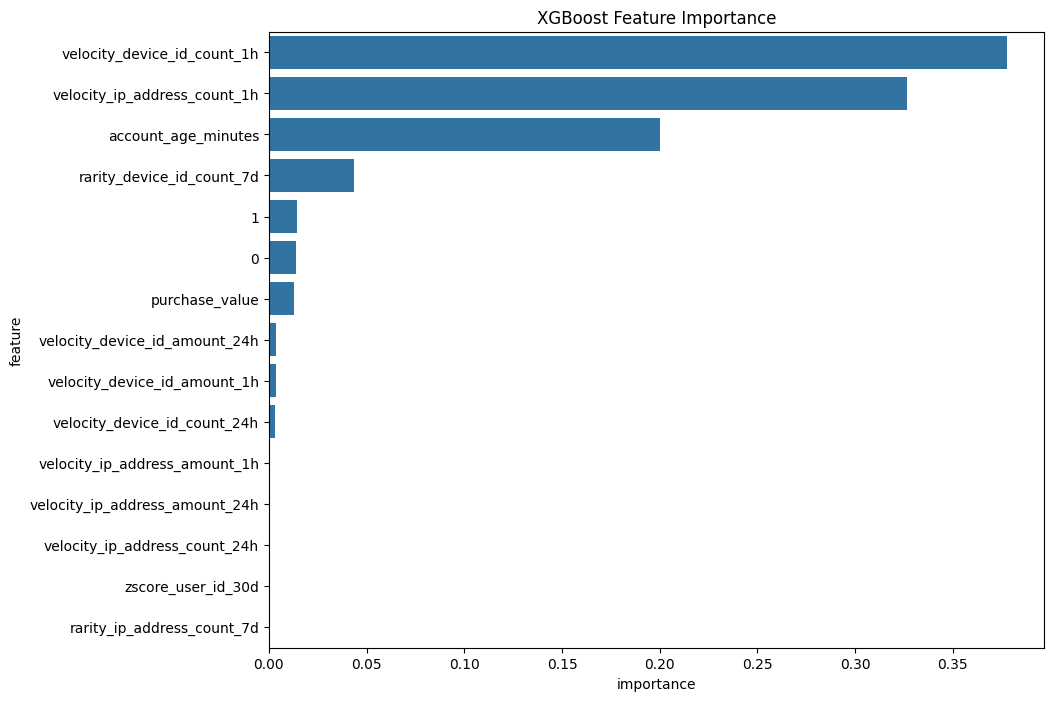

--- Top 10 Features ---
                          feature  importance
2     velocity_device_id_count_1h    0.377699
6    velocity_ip_address_count_1h    0.326651
1             account_age_minutes    0.200286
10      rarity_device_id_count_7d    0.043782
14                              1    0.014419
13                              0    0.013839
0                  purchase_value    0.012979
5   velocity_device_id_amount_24h    0.003723
3    velocity_device_id_amount_1h    0.003582
4    velocity_device_id_count_24h    0.003039


In [10]:
# --- 13. Feature Importance Analysis ---

preprocessor_trained = xgb_pipeline.named_steps['preprocessor']
model_trained = xgb_pipeline.named_steps['model']

# Get feature names reliably from the preprocessor
try:
    num_features = preprocessor_trained.named_transformers_['num'].get_feature_names_out()
    cat_features = preprocessor_trained.named_transformers_['cat'].get_feature_names_out()
    all_feature_names = list(num_features) + list(cat_features)
except Exception:
    # Fallback for older sklearn versions
    all_feature_names = NUMERIC_FEATURES + CATEGORICAL_FEATURES

# Get importances
importances = model_trained.feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('XGBoost Feature Importance')
plt.show()

# Print top 10
print("--- Top 10 Features ---")
print(importance_df.head(10))

Optimizing threshold for XGBoost (AUC: 0.5021)

--- Optimal Business Threshold ---
Optimal Threshold: 0.3797
Minimum Expected Cost on Test Set: $136,960.00

--- Metrics at Optimal Threshold ---
F1-Score: 0.0713 (Primary secondary metric)
Precision: 0.0542
Recall: 0.1044


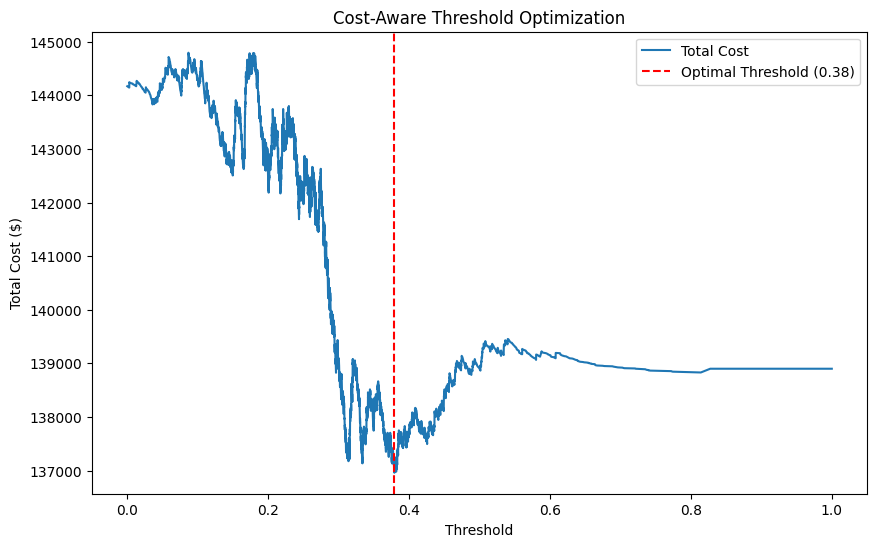

In [11]:
# --- 14. Threshold Optimization (Cost-Aware) ---
print(f"Optimizing threshold for XGBoost (AUC: {auc_xgb:.4f})")

# Define our costs from Task 1
COST_FP = 5  # Cost of a False Positive (review)
COST_FN = 100 # Cost of a False Negative (fraud loss)

# Get precision, recall, and thresholds from the test set probabilities
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_xgb)

# We add a 1.0 to the thresholds to align with precision/recall
# as they have one more element
# thresholds array is 1 shorter than precision/recall
full_thresholds = np.append(thresholds, 1.0)

# Calculate the total number of Positive (Fraud) and Negative (Not Fraud) in the test set
N_P = y_test.sum()
N_N = len(y_test) - N_P

# Calculate cost for each threshold
total_cost = []
for p, r in zip(precision, recall):
    
    # Handle precision=0 case
    if p == 0:
        fp = 0 # If precision is 0, TP is 0, so FP is 0
    else:
        tp = N_P * r
        fp = (tp / p) - tp
        
    fn = N_P * (1 - r)
    
    cost = (fp * COST_FP) + (fn * COST_FN)
    total_cost.append(cost)

# Find the threshold that minimizes cost
optimal_idx = np.argmin(total_cost)
optimal_threshold = full_thresholds[optimal_idx]
min_cost = total_cost[optimal_idx]

print(f"\n--- Optimal Business Threshold ---")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Minimum Expected Cost on Test Set: ${min_cost:,.2f}")

# --- Calculate final metrics at this optimal threshold ---
y_pred_optimal = (y_pred_proba_xgb > optimal_threshold).astype(int)
f1_optimal = f1_score(y_test, y_pred_optimal)
precision_optimal = precision_score(y_test, y_pred_optimal)
recall_optimal = recall_score(y_test, y_pred_optimal)

print(f"\n--- Metrics at Optimal Threshold ---")
print(f"F1-Score: {f1_optimal:.4f} (Primary secondary metric)")
print(f"Precision: {precision_optimal:.4f}")
print(f"Recall: {recall_optimal:.4f}")

# Plot the cost curve
plt.figure(figsize=(10, 6))
plt.plot(full_thresholds, total_cost, label='Total Cost') 
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.title('Cost-Aware Threshold Optimization')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.legend()
plt.show()

In [25]:
!pip install mlflow


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\DineshRaj\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [28]:
!pip show mlflow

Name: mlflow
Version: 3.5.1
Summary: MLflow is an open source platform for the complete machine learning lifecycle
Home-page: 
Author: 
Author-email: 
License: Copyright 2018 Databricks, Inc.  All rights reserved.

                                Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or i

In [29]:
import sys

# This is the path you provided from 'pip show mlflow'
install_path = r'C:\Users\DineshRaj\AppData\Local\Programs\Python\Python311\Lib\site-packages'

# Add the path to your current session
if install_path not in sys.path:
    sys.path.append(install_path)
    print(f"Added {install_path} to system path.")
else:
    print("Path is already in sys.path.")

Added C:\Users\DineshRaj\AppData\Local\Programs\Python\Python311\Lib\site-packages to system path.


In [30]:
import mlflow
import mlflow.sklearn

print("Successfully imported mlflow!")

Successfully imported mlflow!


In [ ]:
import mlflow
import mlflow.sklearn

# Set the experiment name
mlflow.set_experiment("Fraud Detection Pipeline")

# Start a new MLflow run
with mlflow.start_run(run_name="XGBoost Run") as run:
    print("Starting MLflow run ...")
    
    # --- 1. Log Parameters ---
    xgb_params = {
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'logloss'
    }
    mlflow.log_params(xgb_params)
    
    # --- 2. Re-create and Train Pipeline ---
    xgb_pipeline_mlflow = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', xgb.XGBClassifier(
            **xgb_params
            # Removed 'use_label_encoder'
        ))
    ])

    print("Training XGBoost model for MLflow...")
    xgb_pipeline_mlflow.fit(X_train, y_train)
    
    # --- 3. Log Metrics ---
    y_pred_proba_xgb = xgb_pipeline_mlflow.predict_proba(X_test)[:, 1]
    auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    
    print(f"Logging metrics: Test AUC = {auc_xgb:.4f}")
    mlflow.log_metric("test_auc", auc_xgb)
    
    # --- 4. Log Model (with Signature) ---
    
    # *** NEW: Create an input example for the signature ***
    # We use a small sample of the training data
    input_example = X_train.head(5)
    
    print("Logging model with signature...")
    mlflow.sklearn.log_model(
        xgb_pipeline_mlflow, 
        "model",
        input_example=input_example  # <-- This fixes the signature warning
    )
    
    print(f"\nMLflow run complete.")
    print(f"Run ID: {run.info.run_id}")

print("\nTo view your experiment, run 'mlflow ui' in your terminal.")

Starting MLflow run (Fixed Warnings)...
Training XGBoost model for MLflow...


2025/11/05 00:17:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logging metrics: Test AUC = 0.5021
Logging model with signature...


C:\Users\DineshRaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
C:\Users\DineshRaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent m


MLflow run complete.
Run ID: a6946b6199684a71baf0fa675be4bf85

To view your experiment, run 'mlflow ui' in your terminal.


In [39]:
import time

# --- 18. Task 8: Register the Best Model ---

print("Starting Task 8: Registering the model...")

# The 'run' variable from the last cell (Task 6) holds the ID we need.
# This assumes 'run' is still in your notebook's memory.
fixed_run_id = run.info.run_id 

# Define a name for the model in the registry
model_name = "FraudDetectionModel"

# Construct the model's URI (its unique path)
model_uri = f"runs:/{fixed_run_id}/model"

print(f"Registering model from run ID: {fixed_run_id}")

# Register the model
# This creates "Version 1" of our model
model_version = mlflow.register_model(
    model_uri=model_uri,
    name=model_name
)

print("\nModel registered successfully!")
print(f"Model Name: {model_version.name}")
print(f"Model Version: {model_version.version}")

# It can take a few seconds for the registration to be fully "ready"
time.sleep(5) 

print("\n--- Task Complete ---")

Registered model 'FraudDetectionModel' already exists. Creating a new version of this model...
2025/11/05 00:41:41 WARNING mlflow.tracking._model_registry.fluent: Run with id a6946b6199684a71baf0fa675be4bf85 has no artifacts at artifact path 'model', registering model based on models:/m-29591889c8814b9da524b145da5f850f instead


Starting Task 8: Registering the model...
Registering model from run ID: a6946b6199684a71baf0fa675be4bf85

Model registered successfully!
Model Name: FraudDetectionModel
Model Version: 2


Created version '2' of model 'FraudDetectionModel'.



--- Task Complete ---


In [40]:
import pandas as pd

# --- 19. Task 9: Load Registered Model for Inference ---

print("Starting Task 9: Loading model from registry...")

# Define the model's name and version
model_name = "FraudDetectionModel"
model_version = 2

# --- 1. Load the Model ---
# This is the key MLflow command for production
# It loads the model using its registered name and version
model_uri = f"models:/{model_name}/{model_version}"

print(f"Loading model from: {model_uri}")
loaded_model = mlflow.pyfunc.load_model(model_uri)

print("Model loaded successfully.")

# --- 2. Create Sample New Data for Inference ---
# Let's use the first 5 rows of our test set as "new" data
new_data = X_test.head(5)

# --- 3. Make Predictions ---
# We use the generic .predict() function
predictions = loaded_model.predict(new_data)

print("\n--- Inference Complete ---")
print("Prediction input (first 5 test samples):")
print(new_data)
print("\nModel predictions (1 = Fraud, 0 = Not Fraud):")
print(predictions)

print("\n--- Task Complete ---")

Starting Task 9: Loading model from registry...
Loading model from: models:/FraudDetectionModel/2
Model loaded successfully.

--- Inference Complete ---
Prediction input (first 5 test samples):
        browser source  purchase_value  account_age_minutes  \
120889   Chrome    Ads              50        138828.500000   
120890   Chrome    SEO              30         51277.583333   
120891  FireFox    Ads              35         98504.716667   
120892       IE    Ads              20        139747.200000   
120893   Chrome    Ads              46        161600.616667   

        velocity_device_id_count_1h  velocity_device_id_amount_1h  \
120889                          0.0                           0.0   
120890                          0.0                           0.0   
120891                          0.0                           0.0   
120892                          0.0                           0.0   
120893                          0.0                           0.0   

        velo